## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

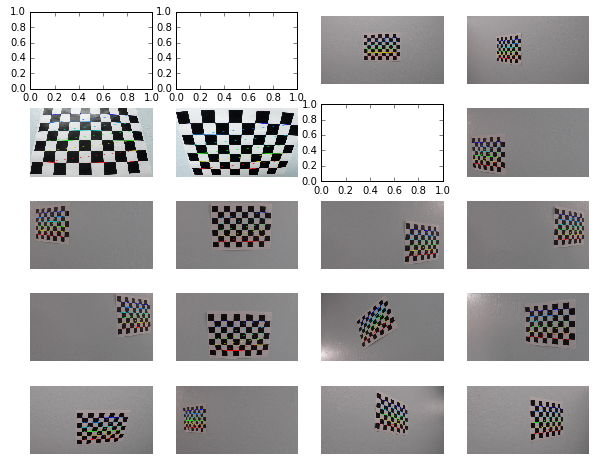

In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(10, 8))

# Step through the list and search for chessboard corners
for ax, fname in zip(axes.flat, images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ax.axis('off')
        ax.imshow(img)

cv2.destroyAllWindows()

## Undirsorting images
Display the undistortion result on the examples of chessboard and real-world images and saving the undistortion parameters for future use:
* Camera Matrix
* Distortion coefficient

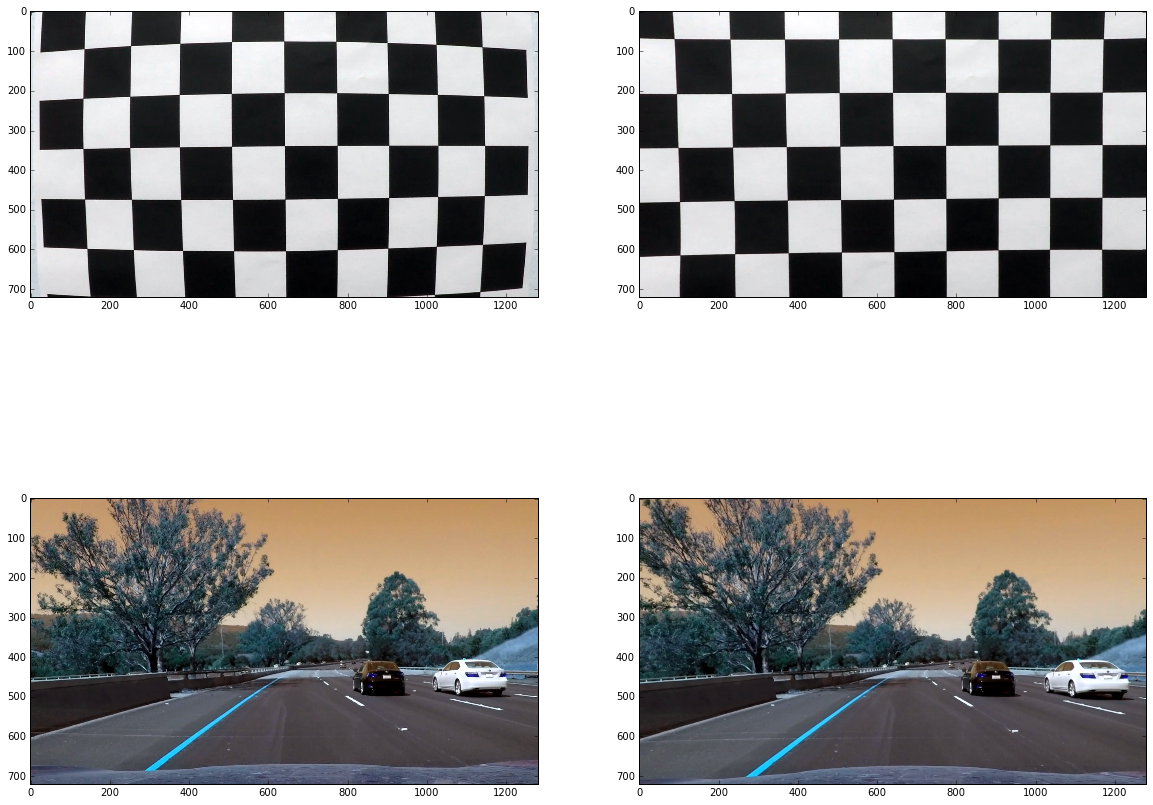

In [3]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

real_img = cv2.imread('./test_images/test6.jpg')
real_dst = cv2.undistort(real_img, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
for ax, img in zip(axes.flat, [img, dst, real_img, real_dst]):
    ax.imshow(img)
    
pickle.dump(
    {
        'mtx': mtx,
        'dist': dist
    }, open('./calibration.p', 'wb')
)

## Transform perspective

In [36]:
def region_of_interest_coords(shape):
    width, height = shape[1], shape[0]
    
    vertical_mark = 0.62
    top, bottom, trapezoid_height = vertical_mark * height, height, (1 - vertical_mark) * height
    
    padding = 0.07
    bottom_left, bottom_right = padding * width, (1 - padding) * width
    
    # trapezoid_ratio = 0.22
    trapezoid_ratio = 0.13
    trapezoid_length = bottom_right - bottom_left
    top_length = trapezoid_length * trapezoid_ratio
    trapezoid_offset = (trapezoid_length - top_length) / 2
    top_left, top_right = bottom_left + trapezoid_offset, bottom_right - trapezoid_offset
    
    trapezoid_coords = np.float32([
        [top_left, top], [top_right, top],
        [bottom_right, bottom], [bottom_left, bottom]
    ])
    
    return trapezoid_coords

In [37]:
def dst_coords(shape):
    width, height = shape[1], shape[0]
    offset = width * 0.07
    
    return np.float32([
        [offset, 0], [width - offset, 0],
        [width - offset, height], [offset, height] 
    ])

In [38]:
def draw_lines(img, coords):
    lines = zip(
        coords,
        np.insert(coords[:-1], 0, coords[-1], axis=0)
    )
        
    for x, y in lines:
        x = tuple(x)
        y = tuple(y)
        cv2.line(img, x, y, [255, 0, 0], 3)
        
    return img

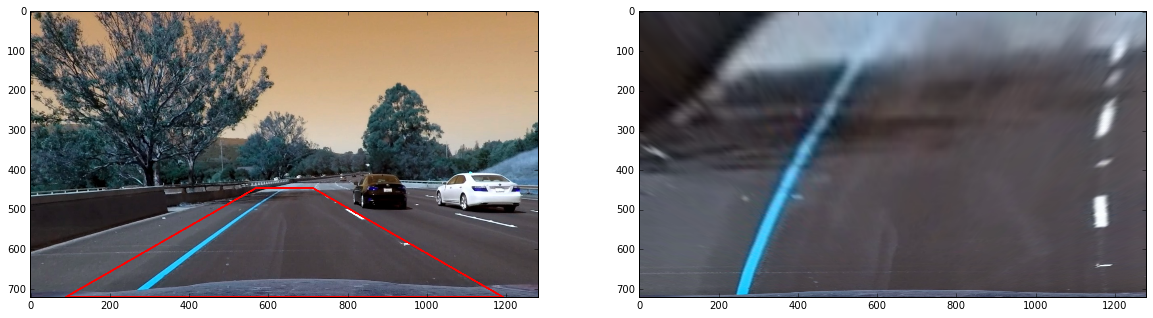

In [39]:
calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
mtx = calibration_parameters['mtx']
dist = calibration_parameters['dist']

lanes_image = cv2.imread('./test_images/test6.jpg')
undistorted = cv2.undistort(lanes_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

src = region_of_interest_coords(undistorted.shape)
dst = dst_coords(undistorted.shape)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(
    undistorted, M, 
    (undistorted.shape[1], undistorted.shape[0])
)

undistorted_lines = draw_lines(undistorted, src)

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
for ax, img in zip(axes.flat, [undistorted_lines, warped]):
    ax.imshow(img)

##Color transformation

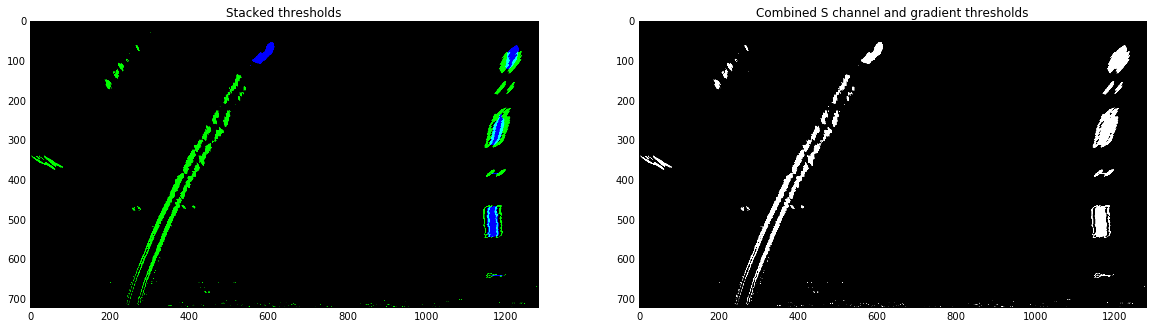

In [40]:
def color_transformation(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Tried L channel, and it actually works better
    s_channel = hls[:,:,1]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    # sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 190
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# color_binary, combined_binary = color_transformation_udacity( cv2.imread('./test_images/test5.jpg') )
color_binary, combined_binary = color_transformation( warped )

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,16))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

##Finding lanes

In [41]:
def polyfit(binary_warped, xm_per_pix=1, ym_per_pix=1):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    return left_fit, right_fit, left_fit_m, right_fit_m

##Calculating curvature

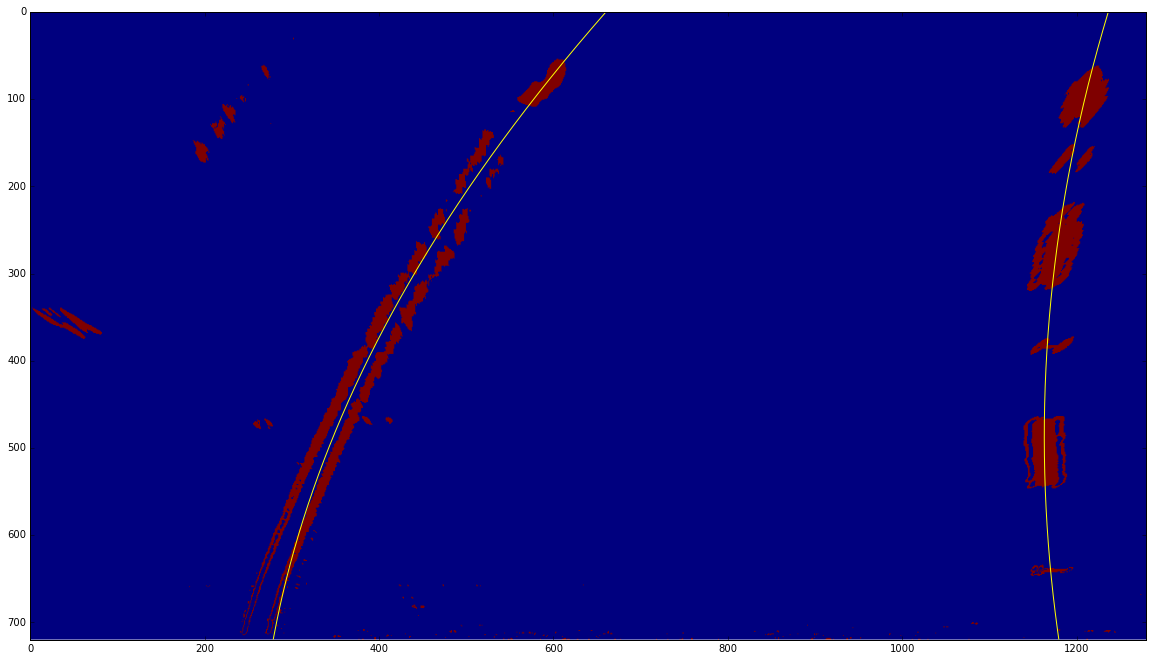

In [42]:
left_fit, right_fit, left_fit_m, right_fit_m = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)

def plot_fit(left_fit, right_fit, combined_binary):
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,16))
    plt.imshow(combined_binary)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

plot_fit(left_fit, right_fit, combined_binary)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [43]:
def curvature_radius(y_eval, left_fit, right_fit, xm_per_pix=3.7/700, ym_per_pix=30/720):
    # Calculate the new radii of curvature
        
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [44]:
def center_postion(y_eval, x_max, left_fit, right_fit, xm_per_pix=3.7/700, ym_per_pix=30/720):
    y_eval *= ym_per_pix
    x_max *= xm_per_pix

    left_line = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    center = left_line + (right_line - left_line) / 2
    delta = (x_max / 2) - center
    
    return center, delta

##Entire pipeline

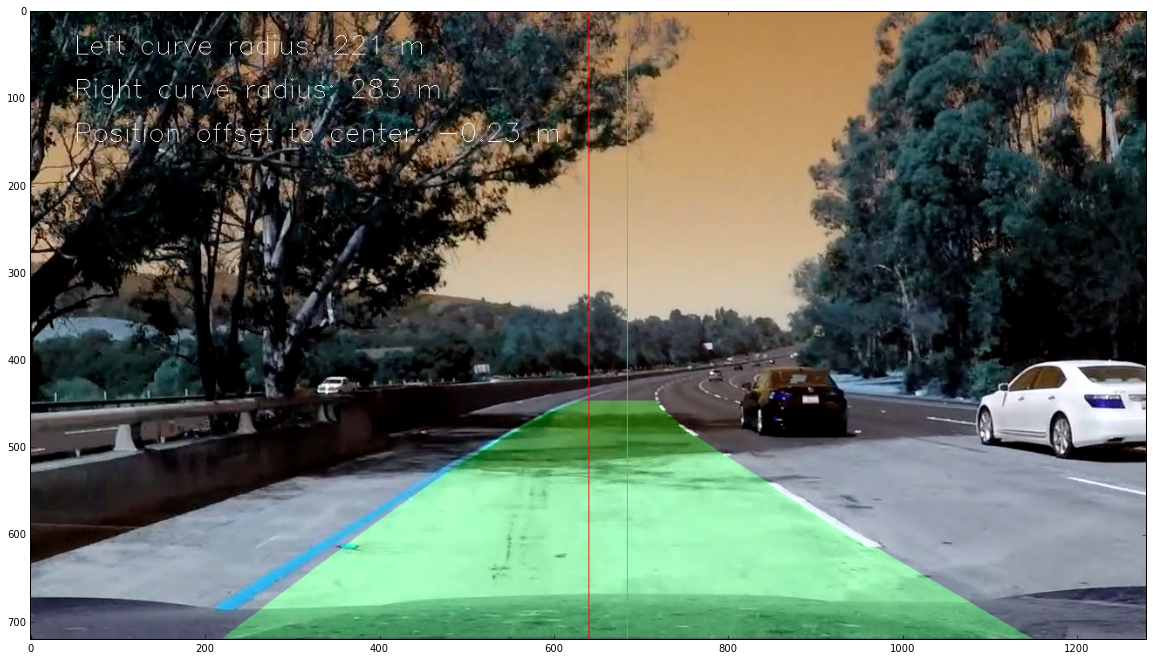

In [45]:
def detect_lanes(img):

    calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
    mtx = calibration_parameters['mtx']
    dist = calibration_parameters['dist']

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    src = region_of_interest_coords(undistorted.shape)
    dst = dst_coords(undistorted.shape)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective( undistorted, M, (undistorted.shape[1], undistorted.shape[0]) )

    color_binary, combined_binary = color_transformation(warped)

    left_fit, right_fit, left_fit_m, right_fit_m = polyfit(combined_binary, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = np.max(ploty)
    left_curverad, right_curverad = curvature_radius(y_eval, left_fit_m, right_fit_m, xm_per_pix=3.7/700, ym_per_pix=30/720)
    center, delta = center_postion(y_eval, img.shape[1], left_fit_m, right_fit_m, xm_per_pix=3.7/700, ym_per_pix=30/720)
    
    return left_fit, right_fit, left_curverad, right_curverad, delta, center

def draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad, delta, center=0):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    res_image = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    cv2.putText(res_image, 'Left curve radius: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2.putText(res_image, 'Right curve radius: {:.0f} m'.format(right_curverad), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2.putText(res_image, 'Position offset to center: {:.2f} m'.format(delta), (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    res_image = cv2.line(
        res_image,
        (int(img.shape[1] / 2), 0),
        (int(img.shape[1] / 2), img.shape[0]),
        [255, 0, 0], 1
    )
    
    res_image = cv2.line(
        res_image,
        (int(center), 0),
        (int(center), img.shape[0]),
        [0, 255, 0], 1
    )
    
    return res_image

class Buf(object):
    def __init__(self, value, length):
        self.buf = np.repeat(value, length)
        
    def append(self, item):
        self.buf = np.insert(self.buf[:-1], 0, item, axis=0)
        
    def filter(self):
        filtered_buf = self.buf[abs(self.buf - np.mean(self.buf)) < 5 * np.std(self.buf)]        
        
class Bufs(object):
    def __init__(self, length):
        self.bufs = None
        self.length = length
    
    def append(self, items):
        if not self.bufs:
            self.bufs = [Buf(item, self.length) for item in items]
            return
        
        for buf, item in zip(self.bufs, items):
            buf.append(item)
    
    def average(self):
        return [
            np.average(buf.buf)
            for buf in self.bufs
        ]
    
    def filter(self):
        for buf in self.bufs:
            buf.filter()
    
bufs = Bufs(25)
def video_pipeline(img):
    left_fit, right_fit, left_curverad, right_curverad, delta, center = detect_lanes(img)
    
    if left_curverad / right_curverad > 0.7 and left_curverad / right_curverad < 1.5: 
        bufs.append([
            left_fit[0], left_fit[1], left_fit[2],
            right_fit[0], right_fit[1], right_fit[2], 
            left_curverad,
            right_curverad,
            delta,
            center
        ])
    
    bufs.filter()
    
    [left_fit[0], left_fit[1], left_fit[2],
    right_fit[0], right_fit[1], right_fit[2], 
    left_curverad,
    right_curverad,
    delta,
    center] = bufs.average()
    
    res_image = draw_lanes(img, left_fit, right_fit, left_curverad, right_curverad, delta, center / xm_per_pix)
    return res_image

res_image = video_pipeline(cv2.imread('./test_images/test5.jpg'))
plt.figure(figsize=(20,16))
plt.imshow(res_image)

##Video

In [46]:
from moviepy.editor import VideoFileClip
white_output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_video.mp4


[MoviePy] Writing video ./output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:10,  9.63it/s]

  0%|          | 2/1261 [00:00<02:09,  9.70it/s]

  0%|          | 4/1261 [00:00<02:05, 10.04it/s]

  0%|          | 6/1261 [00:00<01:58, 10.57it/s]

  1%|          | 8/1261 [00:00<01:55, 10.81it/s]

  1%|          | 10/1261 [00:00<01:55, 10.85it/s]

  1%|          | 12/1261 [00:01<01:54, 10.90it/s]

  1%|          | 14/1261 [00:01<01:54, 10.91it/s]

  1%|▏         | 16/1261 [00:01<01:53, 10.97it/s]

  1%|▏         | 18/1261 [00:01<01:50, 11.23it/s]

  2%|▏         | 20/1261 [00:01<01:51, 11.10it/s]

  2%|▏         | 22/1261 [00:02<02:06,  9.83it/s]

  2%|▏         | 23/1261 [00:02<02:08,  9.60it/s]

  2%|▏         | 25/1261 [00:02<02:05,  9.87it/s]

  2%|▏         | 27/1261 [00:02<02:05,  9.80it/s]

  2%|▏         | 28/1261 [00:02<02:07,  9.65it/s]

  2%|▏         | 30/1261 [00:02<02:15,  9.06it/s]

  2%|▏         | 31/1261 [00:03<02:19,  8.81it/s]

  3%|▎         | 32/1261 [00:03<02:20,  8.76it/s]

  3%|▎         | 33/1261 [00:03<02:48,  7.30it/s]

  3%|▎         | 34/1261 [00:03<04:15,  4.80it/s]

  3%|▎         | 35/1261 [00:03<04:03,  5.03it/s]

  3%|▎         | 36/1261 [00:04<03:40,  5.57it/s]

  3%|▎         | 37/1261 [00:04<03:31,  5.80it/s]

  3%|▎         | 38/1261 [00:04<03:16,  6.21it/s]

  3%|▎         | 39/1261 [00:04<03:31,  5.77it/s]

  3%|▎         | 40/1261 [00:04<03:39,  5.55it/s]

  3%|▎         | 41/1261 [00:04<03:18,  6.15it/s]

  3%|▎         | 42/1261 [00:04<02:56,  6.90it/s]

  3%|▎         | 44/1261 [00:05<02:40,  7.58it/s]

  4%|▎         | 46/1261 [00:05<02:26,  8.27it/s]

  4%|▎         | 47/1261 [00:05<02:20,  8.61it/s]

  4%|▍         | 48/1261 [00:05<02:17,  8.83it/s]

  4%|▍         | 49/1261 [00:05<02:12,  9.15it/s]

  4%|▍         | 51/1261 [00:05<02:06,  9.58it/s]

  4%|▍         | 52/1261 [00:05<02:06,  9.53it/s]

  4%|▍         | 53/1261 [00:06<02:11,  9.18it/s]

  4%|▍         | 54/1261 [00:06<02:08,  9.40it/s]

  4%|▍         | 55/1261 [00:06<02:09,  9.30it/s]

  4%|▍         | 56/1261 [00:06<02:22,  8.47it/s]

  5%|▍         | 58/1261 [00:06<02:12,  9.11it/s]

  5%|▍         | 59/1261 [00:06<02:11,  9.11it/s]

  5%|▍         | 60/1261 [00:06<02:14,  8.91it/s]

  5%|▍         | 61/1261 [00:06<02:20,  8.53it/s]

  5%|▍         | 62/1261 [00:07<02:16,  8.79it/s]

  5%|▍         | 63/1261 [00:07<02:13,  8.99it/s]

  5%|▌         | 65/1261 [00:07<02:08,  9.29it/s]

  5%|▌         | 66/1261 [00:07<02:08,  9.32it/s]

  5%|▌         | 68/1261 [00:07<02:00,  9.88it/s]

  6%|▌         | 70/1261 [00:07<01:53, 10.47it/s]

  6%|▌         | 72/1261 [00:08<01:51, 10.64it/s]

  6%|▌         | 74/1261 [00:08<01:51, 10.68it/s]

  6%|▌         | 76/1261 [00:08<01:49, 10.80it/s]

  6%|▌         | 78/1261 [00:08<01:49, 10.80it/s]

  6%|▋         | 80/1261 [00:08<01:48, 10.85it/s]

  7%|▋         | 82/1261 [00:08<01:56, 10.09it/s]

  7%|▋         | 84/1261 [00:09<02:14,  8.77it/s]

  7%|▋         | 86/1261 [00:09<02:05,  9.35it/s]

  7%|▋         | 88/1261 [00:09<02:01,  9.63it/s]

  7%|▋         | 90/1261 [00:09<01:57,  9.98it/s]

  7%|▋         | 92/1261 [00:09<01:52, 10.42it/s]

  7%|▋         | 94/1261 [00:10<01:47, 10.81it/s]

  8%|▊         | 96/1261 [00:10<01:47, 10.85it/s]

  8%|▊         | 98/1261 [00:10<01:46, 10.93it/s]

  8%|▊         | 100/1261 [00:10<01:51, 10.42it/s]

  8%|▊         | 102/1261 [00:10<01:51, 10.41it/s]

  8%|▊         | 104/1261 [00:11<01:51, 10.40it/s]

  8%|▊         | 106/1261 [00:11<01:48, 10.62it/s]

  9%|▊         | 108/1261 [00:11<01:47, 10.72it/s]

  9%|▊         | 110/1261 [00:11<01:47, 10.73it/s]

  9%|▉         | 112/1261 [00:11<01:49, 10.45it/s]

  9%|▉         | 114/1261 [00:12<01:53, 10.15it/s]

  9%|▉         | 116/1261 [00:12<01:54, 10.03it/s]

  9%|▉         | 118/1261 [00:12<01:52, 10.16it/s]

 10%|▉         | 120/1261 [00:12<01:48, 10.56it/s]

 10%|▉         | 122/1261 [00:12<01:43, 11.00it/s]

 10%|▉         | 124/1261 [00:13<01:46, 10.63it/s]

 10%|▉         | 126/1261 [00:13<01:48, 10.42it/s]

 10%|█         | 128/1261 [00:13<01:49, 10.34it/s]

 10%|█         | 130/1261 [00:13<01:46, 10.61it/s]

 10%|█         | 132/1261 [00:13<01:44, 10.80it/s]

 11%|█         | 134/1261 [00:13<01:43, 10.85it/s]

 11%|█         | 136/1261 [00:14<01:48, 10.37it/s]

 11%|█         | 138/1261 [00:14<01:51, 10.04it/s]

 11%|█         | 140/1261 [00:14<01:55,  9.72it/s]

 11%|█         | 141/1261 [00:14<01:55,  9.68it/s]

 11%|█▏        | 143/1261 [00:14<01:51, 10.01it/s]

 11%|█▏        | 145/1261 [00:15<01:45, 10.55it/s]

 12%|█▏        | 147/1261 [00:15<01:45, 10.57it/s]

 12%|█▏        | 149/1261 [00:15<01:44, 10.68it/s]

 12%|█▏        | 151/1261 [00:15<01:44, 10.67it/s]

 12%|█▏        | 153/1261 [00:15<01:43, 10.69it/s]

 12%|█▏        | 155/1261 [00:15<01:41, 10.95it/s]

 12%|█▏        | 157/1261 [00:16<01:41, 10.90it/s]

 13%|█▎        | 159/1261 [00:16<01:46, 10.38it/s]

 13%|█▎        | 161/1261 [00:16<01:47, 10.19it/s]

 13%|█▎        | 163/1261 [00:16<01:48, 10.15it/s]

 13%|█▎        | 165/1261 [00:16<01:48, 10.15it/s]

 13%|█▎        | 167/1261 [00:17<01:51,  9.82it/s]

 13%|█▎        | 169/1261 [00:17<01:44, 10.41it/s]

 14%|█▎        | 171/1261 [00:17<01:42, 10.65it/s]

 14%|█▎        | 173/1261 [00:17<01:42, 10.64it/s]

 14%|█▍        | 175/1261 [00:17<01:42, 10.57it/s]

 14%|█▍        | 177/1261 [00:18<01:42, 10.61it/s]

 14%|█▍        | 179/1261 [00:18<01:39, 10.86it/s]

 14%|█▍        | 181/1261 [00:18<01:36, 11.17it/s]

 15%|█▍        | 183/1261 [00:18<01:33, 11.48it/s]

 15%|█▍        | 185/1261 [00:18<01:33, 11.48it/s]

 15%|█▍        | 187/1261 [00:18<01:33, 11.47it/s]

 15%|█▍        | 189/1261 [00:19<01:34, 11.39it/s]

 15%|█▌        | 191/1261 [00:19<01:32, 11.61it/s]

 15%|█▌        | 193/1261 [00:19<01:31, 11.73it/s]

 15%|█▌        | 195/1261 [00:19<01:28, 11.99it/s]

 16%|█▌        | 197/1261 [00:19<01:30, 11.79it/s]

 16%|█▌        | 199/1261 [00:19<01:32, 11.53it/s]

 16%|█▌        | 201/1261 [00:20<01:34, 11.26it/s]

 16%|█▌        | 203/1261 [00:20<01:36, 11.02it/s]

 16%|█▋        | 205/1261 [00:20<01:33, 11.24it/s]

 16%|█▋        | 207/1261 [00:20<01:32, 11.42it/s]

 17%|█▋        | 209/1261 [00:20<01:32, 11.34it/s]

 17%|█▋        | 211/1261 [00:21<01:34, 11.06it/s]

 17%|█▋        | 213/1261 [00:21<01:33, 11.15it/s]

 17%|█▋        | 215/1261 [00:21<01:34, 11.02it/s]

 17%|█▋        | 217/1261 [00:21<01:33, 11.22it/s]

 17%|█▋        | 219/1261 [00:21<01:29, 11.65it/s]

 18%|█▊        | 221/1261 [00:21<01:29, 11.68it/s]

 18%|█▊        | 223/1261 [00:22<01:31, 11.29it/s]

 18%|█▊        | 225/1261 [00:22<01:32, 11.19it/s]

 18%|█▊        | 227/1261 [00:22<01:33, 11.11it/s]

 18%|█▊        | 229/1261 [00:22<01:30, 11.34it/s]

 18%|█▊        | 231/1261 [00:22<01:29, 11.57it/s]

 18%|█▊        | 233/1261 [00:22<01:27, 11.76it/s]

 19%|█▊        | 235/1261 [00:23<01:29, 11.41it/s]

 19%|█▉        | 237/1261 [00:23<01:29, 11.38it/s]

 19%|█▉        | 239/1261 [00:23<01:30, 11.31it/s]

 19%|█▉        | 241/1261 [00:23<01:27, 11.62it/s]

 19%|█▉        | 243/1261 [00:23<01:26, 11.81it/s]

 19%|█▉        | 245/1261 [00:24<01:25, 11.91it/s]

 20%|█▉        | 247/1261 [00:24<01:30, 11.21it/s]

 20%|█▉        | 249/1261 [00:24<01:32, 10.95it/s]

 20%|█▉        | 251/1261 [00:24<01:35, 10.56it/s]

 20%|██        | 253/1261 [00:24<01:35, 10.61it/s]

 20%|██        | 255/1261 [00:25<01:54,  8.77it/s]

 20%|██        | 256/1261 [00:25<02:02,  8.21it/s]

 20%|██        | 257/1261 [00:25<02:00,  8.30it/s]

 20%|██        | 258/1261 [00:25<02:01,  8.27it/s]

 21%|██        | 259/1261 [00:25<01:55,  8.69it/s]

 21%|██        | 261/1261 [00:25<01:46,  9.42it/s]

 21%|██        | 263/1261 [00:25<01:40,  9.94it/s]

 21%|██        | 265/1261 [00:26<01:50,  9.01it/s]

 21%|██        | 267/1261 [00:26<01:45,  9.44it/s]

 21%|██▏       | 269/1261 [00:26<01:40,  9.84it/s]

 21%|██▏       | 271/1261 [00:26<01:38, 10.05it/s]

 22%|██▏       | 273/1261 [00:26<01:34, 10.42it/s]

 22%|██▏       | 275/1261 [00:27<01:33, 10.55it/s]

 22%|██▏       | 277/1261 [00:27<01:31, 10.79it/s]

 22%|██▏       | 279/1261 [00:27<01:30, 10.87it/s]

 22%|██▏       | 281/1261 [00:27<01:27, 11.18it/s]

 22%|██▏       | 283/1261 [00:27<01:28, 10.99it/s]

 23%|██▎       | 285/1261 [00:28<01:32, 10.59it/s]

 23%|██▎       | 287/1261 [00:28<01:39,  9.77it/s]

 23%|██▎       | 289/1261 [00:28<01:35, 10.16it/s]

 23%|██▎       | 291/1261 [00:28<01:33, 10.43it/s]

 23%|██▎       | 293/1261 [00:28<01:32, 10.51it/s]

 23%|██▎       | 295/1261 [00:29<01:33, 10.29it/s]

 24%|██▎       | 297/1261 [00:29<01:36, 10.01it/s]

 24%|██▎       | 299/1261 [00:29<01:35, 10.06it/s]

 24%|██▍       | 301/1261 [00:29<01:32, 10.39it/s]

 24%|██▍       | 303/1261 [00:29<01:31, 10.43it/s]

 24%|██▍       | 305/1261 [00:29<01:26, 11.00it/s]

 24%|██▍       | 307/1261 [00:30<01:32, 10.34it/s]

 25%|██▍       | 309/1261 [00:30<01:33, 10.20it/s]

 25%|██▍       | 311/1261 [00:30<01:34, 10.08it/s]

 25%|██▍       | 313/1261 [00:30<01:36,  9.79it/s]

 25%|██▍       | 314/1261 [00:30<01:37,  9.70it/s]

 25%|██▍       | 315/1261 [00:31<02:05,  7.52it/s]

 25%|██▌       | 316/1261 [00:31<02:05,  7.51it/s]

 25%|██▌       | 318/1261 [00:31<01:58,  7.99it/s]

 25%|██▌       | 319/1261 [00:31<01:57,  8.01it/s]

 25%|██▌       | 320/1261 [00:31<01:57,  8.00it/s]

 26%|██▌       | 322/1261 [00:31<01:51,  8.42it/s]

 26%|██▌       | 324/1261 [00:32<01:44,  9.00it/s]

 26%|██▌       | 326/1261 [00:32<01:39,  9.44it/s]

 26%|██▌       | 328/1261 [00:32<01:34,  9.85it/s]

 26%|██▌       | 330/1261 [00:32<01:31, 10.13it/s]

 26%|██▋       | 332/1261 [00:32<01:30, 10.25it/s]

 26%|██▋       | 334/1261 [00:33<01:33,  9.92it/s]

 27%|██▋       | 336/1261 [00:33<02:09,  7.12it/s]

 27%|██▋       | 337/1261 [00:33<02:15,  6.81it/s]

 27%|██▋       | 338/1261 [00:33<02:06,  7.29it/s]

 27%|██▋       | 339/1261 [00:33<01:58,  7.79it/s]

 27%|██▋       | 340/1261 [00:34<01:55,  8.00it/s]

 27%|██▋       | 341/1261 [00:34<01:49,  8.39it/s]

 27%|██▋       | 342/1261 [00:34<01:51,  8.21it/s]

 27%|██▋       | 343/1261 [00:34<01:52,  8.17it/s]

 27%|██▋       | 344/1261 [00:34<01:57,  7.80it/s]

 27%|██▋       | 345/1261 [00:34<02:00,  7.63it/s]

 27%|██▋       | 346/1261 [00:34<02:04,  7.36it/s]

 28%|██▊       | 347/1261 [00:34<02:03,  7.43it/s]

 28%|██▊       | 348/1261 [00:35<02:14,  6.77it/s]

 28%|██▊       | 349/1261 [00:35<02:32,  5.96it/s]

 28%|██▊       | 350/1261 [00:35<02:22,  6.38it/s]

 28%|██▊       | 351/1261 [00:35<02:13,  6.84it/s]

 28%|██▊       | 353/1261 [00:35<01:57,  7.76it/s]

 28%|██▊       | 355/1261 [00:35<01:46,  8.51it/s]

 28%|██▊       | 357/1261 [00:36<01:37,  9.30it/s]

 28%|██▊       | 359/1261 [00:36<01:33,  9.70it/s]

 29%|██▊       | 361/1261 [00:36<01:28, 10.15it/s]

 29%|██▉       | 363/1261 [00:36<01:26, 10.34it/s]

 29%|██▉       | 365/1261 [00:36<01:27, 10.24it/s]

 29%|██▉       | 367/1261 [00:37<01:26, 10.33it/s]

 29%|██▉       | 369/1261 [00:37<01:23, 10.69it/s]

 29%|██▉       | 371/1261 [00:37<01:21, 10.87it/s]

 30%|██▉       | 373/1261 [00:37<01:20, 11.02it/s]

 30%|██▉       | 375/1261 [00:37<01:18, 11.29it/s]

 30%|██▉       | 377/1261 [00:37<01:15, 11.65it/s]

 30%|███       | 379/1261 [00:38<01:16, 11.54it/s]

 30%|███       | 381/1261 [00:38<01:16, 11.53it/s]

 30%|███       | 383/1261 [00:38<01:15, 11.68it/s]

 31%|███       | 385/1261 [00:38<01:13, 11.93it/s]

 31%|███       | 387/1261 [00:38<01:12, 12.10it/s]

 31%|███       | 389/1261 [00:38<01:10, 12.32it/s]

 31%|███       | 391/1261 [00:39<01:11, 12.15it/s]

 31%|███       | 393/1261 [00:39<01:11, 12.21it/s]

 31%|███▏      | 395/1261 [00:39<01:12, 11.95it/s]

 31%|███▏      | 397/1261 [00:39<01:15, 11.42it/s]

 32%|███▏      | 399/1261 [00:39<01:16, 11.23it/s]

 32%|███▏      | 401/1261 [00:39<01:15, 11.43it/s]

 32%|███▏      | 403/1261 [00:40<01:15, 11.33it/s]

 32%|███▏      | 405/1261 [00:40<01:14, 11.52it/s]

 32%|███▏      | 407/1261 [00:40<01:16, 11.23it/s]

 32%|███▏      | 409/1261 [00:40<01:15, 11.22it/s]

 33%|███▎      | 411/1261 [00:40<01:15, 11.20it/s]

 33%|███▎      | 413/1261 [00:41<01:14, 11.32it/s]

 33%|███▎      | 415/1261 [00:41<01:15, 11.24it/s]

 33%|███▎      | 417/1261 [00:41<01:14, 11.34it/s]

 33%|███▎      | 419/1261 [00:41<01:16, 11.07it/s]

 33%|███▎      | 421/1261 [00:41<01:15, 11.10it/s]

 34%|███▎      | 423/1261 [00:41<01:15, 11.13it/s]

 34%|███▎      | 425/1261 [00:42<01:15, 11.06it/s]

 34%|███▍      | 427/1261 [00:42<01:16, 10.88it/s]

 34%|███▍      | 429/1261 [00:42<01:16, 10.92it/s]

 34%|███▍      | 431/1261 [00:42<01:18, 10.52it/s]

 34%|███▍      | 433/1261 [00:42<01:18, 10.55it/s]

 34%|███▍      | 435/1261 [00:43<01:17, 10.68it/s]

 35%|███▍      | 437/1261 [00:43<01:17, 10.59it/s]

 35%|███▍      | 439/1261 [00:43<01:15, 10.85it/s]

 35%|███▍      | 441/1261 [00:43<01:21, 10.05it/s]

 35%|███▌      | 443/1261 [00:43<01:24,  9.73it/s]

 35%|███▌      | 444/1261 [00:44<01:30,  9.01it/s]

 35%|███▌      | 446/1261 [00:44<01:24,  9.66it/s]

 36%|███▌      | 448/1261 [00:44<01:18, 10.33it/s]

 36%|███▌      | 450/1261 [00:44<01:17, 10.53it/s]

 36%|███▌      | 452/1261 [00:44<01:22,  9.84it/s]

 36%|███▌      | 454/1261 [00:44<01:19, 10.10it/s]

 36%|███▌      | 456/1261 [00:45<01:20, 10.01it/s]

 36%|███▋      | 458/1261 [00:45<01:18, 10.25it/s]

 36%|███▋      | 460/1261 [00:45<01:25,  9.41it/s]

 37%|███▋      | 461/1261 [00:45<01:28,  9.06it/s]

 37%|███▋      | 462/1261 [00:45<01:28,  9.05it/s]

 37%|███▋      | 463/1261 [00:45<01:27,  9.11it/s]

 37%|███▋      | 464/1261 [00:46<01:32,  8.59it/s]

 37%|███▋      | 465/1261 [00:46<01:41,  7.84it/s]

 37%|███▋      | 466/1261 [00:46<01:45,  7.54it/s]

 37%|███▋      | 467/1261 [00:46<01:55,  6.86it/s]

 37%|███▋      | 468/1261 [00:46<01:53,  7.01it/s]

 37%|███▋      | 469/1261 [00:46<01:48,  7.33it/s]

 37%|███▋      | 470/1261 [00:46<01:48,  7.31it/s]

 37%|███▋      | 471/1261 [00:47<01:47,  7.32it/s]

 37%|███▋      | 472/1261 [00:47<01:51,  7.11it/s]

 38%|███▊      | 473/1261 [00:47<02:03,  6.38it/s]

 38%|███▊      | 474/1261 [00:47<02:19,  5.66it/s]

 38%|███▊      | 475/1261 [00:47<02:16,  5.77it/s]

 38%|███▊      | 476/1261 [00:47<02:08,  6.13it/s]

 38%|███▊      | 477/1261 [00:48<01:59,  6.56it/s]

 38%|███▊      | 478/1261 [00:48<02:10,  6.02it/s]

 38%|███▊      | 479/1261 [00:48<02:03,  6.35it/s]

 38%|███▊      | 480/1261 [00:48<01:52,  6.94it/s]

 38%|███▊      | 482/1261 [00:48<01:39,  7.83it/s]

 38%|███▊      | 484/1261 [00:48<01:29,  8.65it/s]

 39%|███▊      | 486/1261 [00:49<01:24,  9.16it/s]

 39%|███▊      | 488/1261 [00:49<01:20,  9.64it/s]

 39%|███▉      | 490/1261 [00:49<01:18,  9.83it/s]

 39%|███▉      | 492/1261 [00:49<01:16, 10.08it/s]

 39%|███▉      | 494/1261 [00:49<01:13, 10.38it/s]

 39%|███▉      | 496/1261 [00:49<01:11, 10.68it/s]

 39%|███▉      | 498/1261 [00:50<01:12, 10.57it/s]

 40%|███▉      | 500/1261 [00:50<01:09, 10.90it/s]

 40%|███▉      | 502/1261 [00:50<01:09, 10.97it/s]

 40%|███▉      | 504/1261 [00:50<01:07, 11.27it/s]

 40%|████      | 506/1261 [00:50<01:05, 11.59it/s]

 40%|████      | 508/1261 [00:51<01:03, 11.89it/s]

 40%|████      | 510/1261 [00:51<01:02, 11.93it/s]

 41%|████      | 512/1261 [00:51<01:03, 11.77it/s]

 41%|████      | 514/1261 [00:51<01:03, 11.69it/s]

 41%|████      | 516/1261 [00:51<01:03, 11.79it/s]

 41%|████      | 518/1261 [00:51<01:01, 11.99it/s]

 41%|████      | 520/1261 [00:52<01:01, 12.05it/s]

 41%|████▏     | 522/1261 [00:52<01:02, 11.86it/s]

 42%|████▏     | 524/1261 [00:52<01:01, 11.90it/s]

 42%|████▏     | 526/1261 [00:52<01:01, 11.94it/s]

 42%|████▏     | 528/1261 [00:52<01:01, 11.87it/s]

 42%|████▏     | 530/1261 [00:52<01:01, 11.98it/s]

 42%|████▏     | 532/1261 [00:53<01:02, 11.74it/s]

 42%|████▏     | 534/1261 [00:53<01:04, 11.23it/s]

 43%|████▎     | 536/1261 [00:53<01:05, 11.01it/s]

 43%|████▎     | 538/1261 [00:53<01:06, 10.86it/s]

 43%|████▎     | 540/1261 [00:53<01:07, 10.62it/s]

 43%|████▎     | 542/1261 [00:54<01:08, 10.51it/s]

 43%|████▎     | 544/1261 [00:54<01:09, 10.37it/s]

 43%|████▎     | 546/1261 [00:54<01:08, 10.43it/s]

 43%|████▎     | 548/1261 [00:54<01:08, 10.34it/s]

 44%|████▎     | 550/1261 [00:54<01:09, 10.28it/s]

 44%|████▍     | 552/1261 [00:54<01:09, 10.25it/s]

 44%|████▍     | 554/1261 [00:55<01:09, 10.23it/s]

 44%|████▍     | 556/1261 [00:55<01:09, 10.10it/s]

 44%|████▍     | 558/1261 [00:55<01:08, 10.24it/s]

 44%|████▍     | 560/1261 [00:55<01:07, 10.31it/s]

 45%|████▍     | 562/1261 [00:55<01:07, 10.38it/s]

 45%|████▍     | 564/1261 [00:56<01:06, 10.53it/s]

 45%|████▍     | 566/1261 [00:56<01:03, 10.89it/s]

 45%|████▌     | 568/1261 [00:56<01:02, 11.17it/s]

 45%|████▌     | 570/1261 [00:56<01:00, 11.40it/s]

 45%|████▌     | 572/1261 [00:56<00:58, 11.73it/s]

 46%|████▌     | 574/1261 [00:56<00:57, 11.95it/s]

 46%|████▌     | 576/1261 [00:57<00:58, 11.79it/s]

 46%|████▌     | 578/1261 [00:57<00:59, 11.55it/s]

 46%|████▌     | 580/1261 [00:57<00:59, 11.42it/s]

 46%|████▌     | 582/1261 [00:57<00:59, 11.39it/s]

 46%|████▋     | 584/1261 [00:57<00:59, 11.29it/s]

 46%|████▋     | 586/1261 [00:58<01:00, 11.23it/s]

 47%|████▋     | 588/1261 [00:58<01:00, 11.20it/s]

 47%|████▋     | 590/1261 [00:58<00:59, 11.21it/s]

 47%|████▋     | 592/1261 [00:58<00:59, 11.29it/s]

 47%|████▋     | 594/1261 [00:58<00:59, 11.22it/s]

 47%|████▋     | 596/1261 [00:58<00:58, 11.35it/s]

 47%|████▋     | 598/1261 [00:59<01:00, 10.97it/s]

 48%|████▊     | 600/1261 [00:59<00:59, 11.06it/s]

 48%|████▊     | 602/1261 [00:59<00:59, 11.08it/s]

 48%|████▊     | 604/1261 [00:59<00:59, 11.13it/s]

 48%|████▊     | 606/1261 [00:59<00:59, 11.01it/s]

 48%|████▊     | 608/1261 [01:00<01:01, 10.56it/s]

 48%|████▊     | 610/1261 [01:00<01:04, 10.16it/s]

 49%|████▊     | 612/1261 [01:00<01:06,  9.83it/s]

 49%|████▊     | 614/1261 [01:00<01:02, 10.30it/s]

 49%|████▉     | 616/1261 [01:00<01:00, 10.59it/s]

 49%|████▉     | 618/1261 [01:01<01:01, 10.42it/s]

 49%|████▉     | 620/1261 [01:01<01:01, 10.37it/s]

 49%|████▉     | 622/1261 [01:01<01:00, 10.62it/s]

 49%|████▉     | 624/1261 [01:01<01:01, 10.33it/s]

 50%|████▉     | 626/1261 [01:01<01:01, 10.26it/s]

 50%|████▉     | 628/1261 [01:02<01:07,  9.39it/s]

 50%|████▉     | 629/1261 [01:02<01:11,  8.88it/s]

 50%|████▉     | 630/1261 [01:02<01:08,  9.17it/s]

 50%|█████     | 631/1261 [01:02<01:13,  8.54it/s]

 50%|█████     | 632/1261 [01:02<01:10,  8.88it/s]

 50%|█████     | 633/1261 [01:02<01:23,  7.50it/s]

 50%|█████     | 634/1261 [01:02<01:28,  7.05it/s]

 50%|█████     | 635/1261 [01:03<01:31,  6.86it/s]

 50%|█████     | 636/1261 [01:03<01:29,  6.96it/s]

 51%|█████     | 637/1261 [01:03<01:28,  7.05it/s]

 51%|█████     | 638/1261 [01:03<01:32,  6.71it/s]

 51%|█████     | 639/1261 [01:03<01:32,  6.70it/s]

 51%|█████     | 640/1261 [01:03<01:37,  6.37it/s]

 51%|█████     | 641/1261 [01:03<01:39,  6.20it/s]

 51%|█████     | 642/1261 [01:04<01:30,  6.83it/s]

 51%|█████     | 643/1261 [01:04<01:22,  7.48it/s]

 51%|█████     | 644/1261 [01:04<01:19,  7.79it/s]

 51%|█████     | 645/1261 [01:04<01:19,  7.78it/s]

 51%|█████     | 646/1261 [01:04<01:13,  8.33it/s]

 51%|█████▏    | 647/1261 [01:04<01:11,  8.54it/s]

 51%|█████▏    | 648/1261 [01:04<01:09,  8.88it/s]

 52%|█████▏    | 650/1261 [01:04<01:04,  9.46it/s]

 52%|█████▏    | 652/1261 [01:05<01:00, 10.00it/s]

 52%|█████▏    | 654/1261 [01:05<00:57, 10.47it/s]

 52%|█████▏    | 656/1261 [01:05<00:58, 10.36it/s]

 52%|█████▏    | 658/1261 [01:05<00:59, 10.13it/s]

 52%|█████▏    | 660/1261 [01:05<00:58, 10.27it/s]

 52%|█████▏    | 662/1261 [01:06<00:57, 10.44it/s]

 53%|█████▎    | 664/1261 [01:06<00:58, 10.24it/s]

 53%|█████▎    | 666/1261 [01:06<00:57, 10.28it/s]

 53%|█████▎    | 668/1261 [01:06<00:57, 10.34it/s]

 53%|█████▎    | 670/1261 [01:06<00:56, 10.41it/s]

 53%|█████▎    | 672/1261 [01:06<00:55, 10.59it/s]

 53%|█████▎    | 674/1261 [01:07<00:54, 10.71it/s]

 54%|█████▎    | 676/1261 [01:07<00:53, 10.92it/s]

 54%|█████▍    | 678/1261 [01:07<00:53, 10.86it/s]

 54%|█████▍    | 680/1261 [01:07<00:54, 10.65it/s]

 54%|█████▍    | 682/1261 [01:07<00:54, 10.65it/s]

 54%|█████▍    | 684/1261 [01:08<00:53, 10.85it/s]

 54%|█████▍    | 686/1261 [01:08<00:52, 10.91it/s]

 55%|█████▍    | 688/1261 [01:08<00:52, 11.02it/s]

 55%|█████▍    | 690/1261 [01:08<00:50, 11.33it/s]

 55%|█████▍    | 692/1261 [01:08<00:49, 11.52it/s]

 55%|█████▌    | 694/1261 [01:08<00:48, 11.57it/s]

 55%|█████▌    | 696/1261 [01:09<00:48, 11.65it/s]

 55%|█████▌    | 698/1261 [01:09<00:47, 11.85it/s]

 56%|█████▌    | 700/1261 [01:09<00:46, 12.09it/s]

 56%|█████▌    | 702/1261 [01:09<00:45, 12.19it/s]

 56%|█████▌    | 704/1261 [01:09<00:45, 12.36it/s]

 56%|█████▌    | 706/1261 [01:09<00:45, 12.25it/s]

 56%|█████▌    | 708/1261 [01:10<00:44, 12.31it/s]

 56%|█████▋    | 710/1261 [01:10<00:44, 12.26it/s]

 56%|█████▋    | 712/1261 [01:10<00:45, 12.19it/s]

 57%|█████▋    | 714/1261 [01:10<00:45, 12.12it/s]

 57%|█████▋    | 716/1261 [01:10<00:44, 12.22it/s]

 57%|█████▋    | 718/1261 [01:10<00:44, 12.16it/s]

 57%|█████▋    | 720/1261 [01:11<00:44, 12.27it/s]

 57%|█████▋    | 722/1261 [01:11<00:44, 12.11it/s]

 57%|█████▋    | 724/1261 [01:11<00:44, 12.19it/s]

 58%|█████▊    | 726/1261 [01:11<00:43, 12.17it/s]

 58%|█████▊    | 728/1261 [01:11<00:43, 12.28it/s]

 58%|█████▊    | 730/1261 [01:11<00:44, 12.02it/s]

 58%|█████▊    | 732/1261 [01:12<00:44, 11.84it/s]

 58%|█████▊    | 734/1261 [01:12<00:44, 11.81it/s]

 58%|█████▊    | 736/1261 [01:12<00:43, 12.00it/s]

 59%|█████▊    | 738/1261 [01:12<00:43, 12.14it/s]

 59%|█████▊    | 740/1261 [01:12<00:42, 12.28it/s]

 59%|█████▉    | 742/1261 [01:12<00:42, 12.18it/s]

 59%|█████▉    | 744/1261 [01:13<00:43, 12.01it/s]

 59%|█████▉    | 746/1261 [01:13<00:43, 11.86it/s]

 59%|█████▉    | 748/1261 [01:13<00:43, 11.89it/s]

 59%|█████▉    | 750/1261 [01:13<00:43, 11.63it/s]

 60%|█████▉    | 752/1261 [01:13<00:43, 11.58it/s]

 60%|█████▉    | 754/1261 [01:13<00:45, 11.25it/s]

 60%|█████▉    | 756/1261 [01:14<00:45, 11.09it/s]

 60%|██████    | 758/1261 [01:14<00:46, 10.82it/s]

 60%|██████    | 760/1261 [01:14<00:45, 11.03it/s]

 60%|██████    | 762/1261 [01:14<00:45, 11.05it/s]

 61%|██████    | 764/1261 [01:14<00:43, 11.34it/s]

 61%|██████    | 766/1261 [01:15<00:44, 11.15it/s]

 61%|██████    | 768/1261 [01:15<00:43, 11.33it/s]

 61%|██████    | 770/1261 [01:15<00:43, 11.31it/s]

 61%|██████    | 772/1261 [01:15<00:42, 11.45it/s]

 61%|██████▏   | 774/1261 [01:15<00:42, 11.50it/s]

 62%|██████▏   | 776/1261 [01:15<00:41, 11.67it/s]

 62%|██████▏   | 778/1261 [01:16<00:42, 11.45it/s]

 62%|██████▏   | 780/1261 [01:16<00:41, 11.53it/s]

 62%|██████▏   | 782/1261 [01:16<00:42, 11.33it/s]

 62%|██████▏   | 784/1261 [01:16<00:43, 10.91it/s]

 62%|██████▏   | 786/1261 [01:16<00:43, 10.89it/s]

 62%|██████▏   | 788/1261 [01:16<00:42, 11.20it/s]

 63%|██████▎   | 790/1261 [01:17<00:43, 10.95it/s]

 63%|██████▎   | 792/1261 [01:17<00:42, 10.94it/s]

 63%|██████▎   | 794/1261 [01:17<00:46, 10.12it/s]

 63%|██████▎   | 796/1261 [01:17<00:45, 10.15it/s]

 63%|██████▎   | 798/1261 [01:17<00:44, 10.49it/s]

 63%|██████▎   | 800/1261 [01:18<00:42, 10.75it/s]

 64%|██████▎   | 802/1261 [01:18<00:41, 10.97it/s]

 64%|██████▍   | 804/1261 [01:18<00:41, 11.06it/s]

 64%|██████▍   | 806/1261 [01:18<00:41, 11.05it/s]

 64%|██████▍   | 808/1261 [01:18<00:40, 11.08it/s]

 64%|██████▍   | 810/1261 [01:19<00:40, 11.27it/s]

 64%|██████▍   | 812/1261 [01:19<00:39, 11.45it/s]

 65%|██████▍   | 814/1261 [01:19<00:38, 11.50it/s]

 65%|██████▍   | 816/1261 [01:19<00:39, 11.18it/s]

 65%|██████▍   | 818/1261 [01:19<00:40, 11.06it/s]

 65%|██████▌   | 820/1261 [01:19<00:39, 11.03it/s]

 65%|██████▌   | 822/1261 [01:20<00:39, 11.16it/s]

 65%|██████▌   | 824/1261 [01:20<00:38, 11.22it/s]

 66%|██████▌   | 826/1261 [01:20<00:38, 11.36it/s]

 66%|██████▌   | 828/1261 [01:20<00:37, 11.51it/s]

 66%|██████▌   | 830/1261 [01:20<00:37, 11.48it/s]

 66%|██████▌   | 832/1261 [01:20<00:37, 11.52it/s]

 66%|██████▌   | 834/1261 [01:21<00:36, 11.67it/s]

 66%|██████▋   | 836/1261 [01:21<00:36, 11.60it/s]

 66%|██████▋   | 838/1261 [01:21<00:36, 11.53it/s]

 67%|██████▋   | 840/1261 [01:21<00:35, 11.71it/s]

 67%|██████▋   | 842/1261 [01:21<00:35, 11.89it/s]

 67%|██████▋   | 844/1261 [01:21<00:34, 11.96it/s]

 67%|██████▋   | 846/1261 [01:22<00:34, 12.07it/s]

 67%|██████▋   | 848/1261 [01:22<00:34, 12.00it/s]

 67%|██████▋   | 850/1261 [01:22<00:34, 11.98it/s]

 68%|██████▊   | 852/1261 [01:22<00:34, 11.89it/s]

 68%|██████▊   | 854/1261 [01:22<00:34, 11.95it/s]

 68%|██████▊   | 856/1261 [01:22<00:33, 12.10it/s]

 68%|██████▊   | 858/1261 [01:23<00:32, 12.24it/s]

 68%|██████▊   | 860/1261 [01:23<00:33, 12.08it/s]

 68%|██████▊   | 862/1261 [01:23<00:33, 11.97it/s]

 69%|██████▊   | 864/1261 [01:23<00:33, 11.80it/s]

 69%|██████▊   | 866/1261 [01:23<00:33, 11.87it/s]

 69%|██████▉   | 868/1261 [01:23<00:33, 11.91it/s]

 69%|██████▉   | 870/1261 [01:24<00:32, 12.08it/s]

 69%|██████▉   | 872/1261 [01:24<00:32, 11.92it/s]

 69%|██████▉   | 874/1261 [01:24<00:32, 11.75it/s]

 69%|██████▉   | 876/1261 [01:24<00:32, 11.78it/s]

 70%|██████▉   | 878/1261 [01:24<00:32, 11.67it/s]

 70%|██████▉   | 880/1261 [01:24<00:32, 11.80it/s]

 70%|██████▉   | 882/1261 [01:25<00:31, 11.85it/s]

 70%|███████   | 884/1261 [01:25<00:32, 11.73it/s]

 70%|███████   | 886/1261 [01:25<00:31, 11.83it/s]

 70%|███████   | 888/1261 [01:25<00:31, 11.99it/s]

 71%|███████   | 890/1261 [01:25<00:30, 12.19it/s]

 71%|███████   | 892/1261 [01:25<00:30, 12.25it/s]

 71%|███████   | 894/1261 [01:26<00:29, 12.32it/s]

 71%|███████   | 896/1261 [01:26<00:29, 12.24it/s]

 71%|███████   | 898/1261 [01:26<00:30, 12.07it/s]

 71%|███████▏  | 900/1261 [01:26<00:30, 11.94it/s]

 72%|███████▏  | 902/1261 [01:26<00:29, 12.16it/s]

 72%|███████▏  | 904/1261 [01:26<00:29, 12.30it/s]

 72%|███████▏  | 906/1261 [01:27<00:28, 12.28it/s]

 72%|███████▏  | 908/1261 [01:27<00:29, 11.83it/s]

 72%|███████▏  | 910/1261 [01:27<00:30, 11.67it/s]

 72%|███████▏  | 912/1261 [01:27<00:30, 11.53it/s]

 72%|███████▏  | 914/1261 [01:27<00:29, 11.70it/s]

 73%|███████▎  | 916/1261 [01:27<00:29, 11.69it/s]

 73%|███████▎  | 918/1261 [01:28<00:29, 11.77it/s]

 73%|███████▎  | 920/1261 [01:28<00:30, 11.24it/s]

 73%|███████▎  | 922/1261 [01:28<00:30, 10.96it/s]

 73%|███████▎  | 924/1261 [01:28<00:30, 11.08it/s]

 73%|███████▎  | 926/1261 [01:28<00:31, 10.56it/s]

 74%|███████▎  | 928/1261 [01:29<00:31, 10.63it/s]

 74%|███████▍  | 930/1261 [01:29<00:30, 10.88it/s]

 74%|███████▍  | 932/1261 [01:29<00:30, 10.70it/s]

 74%|███████▍  | 934/1261 [01:29<00:32, 10.17it/s]

 74%|███████▍  | 936/1261 [01:29<00:33,  9.73it/s]

 74%|███████▍  | 937/1261 [01:30<00:36,  8.90it/s]

 74%|███████▍  | 938/1261 [01:30<00:37,  8.70it/s]

 74%|███████▍  | 939/1261 [01:30<00:36,  8.94it/s]

 75%|███████▍  | 940/1261 [01:30<00:35,  9.00it/s]

 75%|███████▍  | 942/1261 [01:30<00:33,  9.52it/s]

 75%|███████▍  | 944/1261 [01:30<00:31, 10.12it/s]

 75%|███████▌  | 946/1261 [01:30<00:29, 10.66it/s]

 75%|███████▌  | 948/1261 [01:31<00:33,  9.23it/s]

 75%|███████▌  | 949/1261 [01:31<00:33,  9.33it/s]

 75%|███████▌  | 951/1261 [01:31<00:32,  9.44it/s]

 75%|███████▌  | 952/1261 [01:31<00:32,  9.55it/s]

 76%|███████▌  | 953/1261 [01:31<00:32,  9.47it/s]

 76%|███████▌  | 954/1261 [01:31<00:32,  9.43it/s]

 76%|███████▌  | 955/1261 [01:31<00:32,  9.36it/s]

 76%|███████▌  | 956/1261 [01:32<00:34,  8.73it/s]

 76%|███████▌  | 957/1261 [01:32<00:33,  9.07it/s]

 76%|███████▌  | 958/1261 [01:32<00:34,  8.81it/s]

 76%|███████▌  | 959/1261 [01:32<00:36,  8.24it/s]

 76%|███████▌  | 960/1261 [01:32<00:37,  8.05it/s]

 76%|███████▌  | 961/1261 [01:32<00:37,  8.06it/s]

 76%|███████▋  | 962/1261 [01:32<00:38,  7.78it/s]

 76%|███████▋  | 963/1261 [01:32<00:36,  8.14it/s]

 76%|███████▋  | 964/1261 [01:33<00:42,  6.97it/s]

 77%|███████▋  | 965/1261 [01:33<00:40,  7.30it/s]

 77%|███████▋  | 967/1261 [01:33<00:36,  8.00it/s]

 77%|███████▋  | 968/1261 [01:33<00:35,  8.24it/s]

 77%|███████▋  | 969/1261 [01:33<00:35,  8.16it/s]

 77%|███████▋  | 970/1261 [01:33<00:34,  8.42it/s]

 77%|███████▋  | 971/1261 [01:33<00:33,  8.67it/s]

 77%|███████▋  | 972/1261 [01:34<00:39,  7.36it/s]

 77%|███████▋  | 973/1261 [01:34<00:38,  7.41it/s]

 77%|███████▋  | 974/1261 [01:34<00:39,  7.33it/s]

 77%|███████▋  | 975/1261 [01:34<00:38,  7.49it/s]

 77%|███████▋  | 976/1261 [01:34<00:38,  7.34it/s]

 77%|███████▋  | 977/1261 [01:34<00:36,  7.76it/s]

 78%|███████▊  | 978/1261 [01:34<00:34,  8.17it/s]

 78%|███████▊  | 979/1261 [01:34<00:33,  8.44it/s]

 78%|███████▊  | 980/1261 [01:35<00:33,  8.28it/s]

 78%|███████▊  | 982/1261 [01:35<00:31,  8.88it/s]

 78%|███████▊  | 984/1261 [01:35<00:30,  9.06it/s]

 78%|███████▊  | 985/1261 [01:35<00:29,  9.21it/s]

 78%|███████▊  | 987/1261 [01:35<00:29,  9.45it/s]

 78%|███████▊  | 988/1261 [01:35<00:28,  9.45it/s]

 78%|███████▊  | 989/1261 [01:35<00:28,  9.53it/s]

 79%|███████▊  | 990/1261 [01:36<00:28,  9.64it/s]

 79%|███████▊  | 991/1261 [01:36<00:27,  9.67it/s]

 79%|███████▊  | 992/1261 [01:36<00:31,  8.50it/s]

 79%|███████▊  | 993/1261 [01:36<00:33,  7.97it/s]

 79%|███████▉  | 994/1261 [01:36<00:33,  8.03it/s]

 79%|███████▉  | 995/1261 [01:36<00:32,  8.28it/s]

 79%|███████▉  | 996/1261 [01:36<00:32,  8.26it/s]

 79%|███████▉  | 997/1261 [01:36<00:31,  8.38it/s]

 79%|███████▉  | 998/1261 [01:37<00:31,  8.41it/s]

 79%|███████▉  | 999/1261 [01:37<00:30,  8.48it/s]

 79%|███████▉  | 1000/1261 [01:37<00:31,  8.36it/s]

 79%|███████▉  | 1001/1261 [01:37<00:30,  8.47it/s]

 79%|███████▉  | 1002/1261 [01:37<00:29,  8.78it/s]

 80%|███████▉  | 1003/1261 [01:37<00:28,  9.09it/s]

 80%|███████▉  | 1004/1261 [01:37<00:28,  9.11it/s]

 80%|███████▉  | 1005/1261 [01:37<00:28,  8.90it/s]

 80%|███████▉  | 1006/1261 [01:37<00:28,  8.86it/s]

 80%|███████▉  | 1007/1261 [01:38<00:27,  9.07it/s]

 80%|███████▉  | 1008/1261 [01:38<00:27,  9.19it/s]

 80%|████████  | 1009/1261 [01:38<00:27,  9.31it/s]

 80%|████████  | 1011/1261 [01:38<00:25,  9.84it/s]

 80%|████████  | 1013/1261 [01:38<00:24, 10.28it/s]

 80%|████████  | 1015/1261 [01:38<00:24, 10.11it/s]

 81%|████████  | 1017/1261 [01:39<00:24, 10.02it/s]

 81%|████████  | 1019/1261 [01:39<00:22, 10.72it/s]

 81%|████████  | 1021/1261 [01:39<00:21, 11.11it/s]

 81%|████████  | 1023/1261 [01:39<00:20, 11.54it/s]

 81%|████████▏ | 1025/1261 [01:39<00:20, 11.51it/s]

 81%|████████▏ | 1027/1261 [01:39<00:20, 11.61it/s]

 82%|████████▏ | 1029/1261 [01:40<00:19, 11.83it/s]

 82%|████████▏ | 1031/1261 [01:40<00:19, 11.86it/s]

 82%|████████▏ | 1033/1261 [01:40<00:20, 11.28it/s]

 82%|████████▏ | 1035/1261 [01:40<00:21, 10.75it/s]

 82%|████████▏ | 1037/1261 [01:40<00:20, 10.81it/s]

 82%|████████▏ | 1039/1261 [01:40<00:20, 10.97it/s]

 83%|████████▎ | 1041/1261 [01:41<00:19, 11.01it/s]

 83%|████████▎ | 1043/1261 [01:41<00:19, 11.28it/s]

 83%|████████▎ | 1045/1261 [01:41<00:18, 11.60it/s]

 83%|████████▎ | 1047/1261 [01:41<00:17, 11.96it/s]

 83%|████████▎ | 1049/1261 [01:41<00:17, 11.96it/s]

 83%|████████▎ | 1051/1261 [01:41<00:18, 11.59it/s]

 84%|████████▎ | 1053/1261 [01:42<00:17, 11.57it/s]

 84%|████████▎ | 1055/1261 [01:42<00:17, 11.55it/s]

 84%|████████▍ | 1057/1261 [01:42<00:17, 11.62it/s]

 84%|████████▍ | 1059/1261 [01:42<00:17, 11.63it/s]

 84%|████████▍ | 1061/1261 [01:42<00:17, 11.60it/s]

 84%|████████▍ | 1063/1261 [01:43<00:17, 11.64it/s]

 84%|████████▍ | 1065/1261 [01:43<00:16, 11.65it/s]

 85%|████████▍ | 1067/1261 [01:43<00:16, 11.44it/s]

 85%|████████▍ | 1069/1261 [01:43<00:16, 11.47it/s]

 85%|████████▍ | 1071/1261 [01:43<00:16, 11.67it/s]

 85%|████████▌ | 1073/1261 [01:43<00:16, 11.55it/s]

 85%|████████▌ | 1075/1261 [01:44<00:16, 11.45it/s]

 85%|████████▌ | 1077/1261 [01:44<00:16, 11.18it/s]

 86%|████████▌ | 1079/1261 [01:44<00:16, 11.10it/s]

 86%|████████▌ | 1081/1261 [01:44<00:15, 11.29it/s]

 86%|████████▌ | 1083/1261 [01:44<00:15, 11.50it/s]

 86%|████████▌ | 1085/1261 [01:44<00:15, 11.45it/s]

 86%|████████▌ | 1087/1261 [01:45<00:15, 11.51it/s]

 86%|████████▋ | 1089/1261 [01:45<00:15, 11.43it/s]

 87%|████████▋ | 1091/1261 [01:45<00:14, 11.43it/s]

 87%|████████▋ | 1093/1261 [01:45<00:14, 11.63it/s]

 87%|████████▋ | 1095/1261 [01:45<00:14, 11.48it/s]

 87%|████████▋ | 1097/1261 [01:46<00:14, 11.23it/s]

 87%|████████▋ | 1099/1261 [01:46<00:14, 11.10it/s]

 87%|████████▋ | 1101/1261 [01:46<00:14, 11.12it/s]

 87%|████████▋ | 1103/1261 [01:46<00:14, 11.24it/s]

 88%|████████▊ | 1105/1261 [01:46<00:13, 11.52it/s]

 88%|████████▊ | 1107/1261 [01:46<00:13, 11.61it/s]

 88%|████████▊ | 1109/1261 [01:47<00:13, 11.46it/s]

 88%|████████▊ | 1111/1261 [01:47<00:13, 10.96it/s]

 88%|████████▊ | 1113/1261 [01:47<00:14, 10.39it/s]

 88%|████████▊ | 1115/1261 [01:47<00:14, 10.37it/s]

 89%|████████▊ | 1117/1261 [01:47<00:13, 10.78it/s]

 89%|████████▊ | 1119/1261 [01:48<00:12, 11.07it/s]

 89%|████████▉ | 1121/1261 [01:48<00:13, 10.75it/s]

 89%|████████▉ | 1123/1261 [01:48<00:12, 10.82it/s]

 89%|████████▉ | 1125/1261 [01:48<00:12, 10.85it/s]

 89%|████████▉ | 1127/1261 [01:48<00:12, 11.03it/s]

 90%|████████▉ | 1129/1261 [01:48<00:12, 10.98it/s]

 90%|████████▉ | 1131/1261 [01:49<00:11, 11.15it/s]

 90%|████████▉ | 1133/1261 [01:49<00:11, 11.01it/s]

 90%|█████████ | 1135/1261 [01:49<00:11, 10.69it/s]

 90%|█████████ | 1137/1261 [01:49<00:11, 10.66it/s]

 90%|█████████ | 1139/1261 [01:49<00:11, 10.64it/s]

 90%|█████████ | 1141/1261 [01:50<00:11, 10.70it/s]

 91%|█████████ | 1143/1261 [01:50<00:11, 10.45it/s]

 91%|█████████ | 1145/1261 [01:50<00:11,  9.81it/s]

 91%|█████████ | 1146/1261 [01:50<00:11,  9.60it/s]

 91%|█████████ | 1147/1261 [01:50<00:13,  8.76it/s]

 91%|█████████ | 1148/1261 [01:50<00:13,  8.55it/s]

 91%|█████████ | 1149/1261 [01:50<00:13,  8.22it/s]

 91%|█████████ | 1150/1261 [01:51<00:13,  8.15it/s]

 91%|█████████▏| 1152/1261 [01:51<00:12,  8.83it/s]

 92%|█████████▏| 1154/1261 [01:51<00:11,  9.46it/s]

 92%|█████████▏| 1156/1261 [01:51<00:10,  9.88it/s]

 92%|█████████▏| 1158/1261 [01:51<00:10, 10.05it/s]

 92%|█████████▏| 1160/1261 [01:52<00:10,  9.41it/s]

 92%|█████████▏| 1161/1261 [01:52<00:10,  9.43it/s]

 92%|█████████▏| 1163/1261 [01:52<00:10,  9.72it/s]

 92%|█████████▏| 1164/1261 [01:52<00:10,  9.36it/s]

 92%|█████████▏| 1165/1261 [01:52<00:10,  9.24it/s]

 92%|█████████▏| 1166/1261 [01:52<00:10,  9.05it/s]

 93%|█████████▎| 1167/1261 [01:52<00:11,  8.36it/s]

 93%|█████████▎| 1168/1261 [01:53<00:11,  7.76it/s]

 93%|█████████▎| 1169/1261 [01:53<00:12,  7.44it/s]

 93%|█████████▎| 1170/1261 [01:53<00:11,  7.97it/s]

 93%|█████████▎| 1172/1261 [01:53<00:12,  7.08it/s]

 93%|█████████▎| 1173/1261 [01:53<00:15,  5.54it/s]

 93%|█████████▎| 1174/1261 [01:54<00:16,  5.25it/s]

 93%|█████████▎| 1175/1261 [01:54<00:17,  5.02it/s]

 93%|█████████▎| 1176/1261 [01:54<00:15,  5.66it/s]

 93%|█████████▎| 1177/1261 [01:54<00:18,  4.47it/s]

 93%|█████████▎| 1178/1261 [01:54<00:17,  4.68it/s]

 93%|█████████▎| 1179/1261 [01:55<00:16,  5.07it/s]

 94%|█████████▎| 1180/1261 [01:55<00:14,  5.50it/s]

 94%|█████████▎| 1181/1261 [01:55<00:12,  6.20it/s]

 94%|█████████▎| 1182/1261 [01:55<00:11,  6.63it/s]

 94%|█████████▍| 1183/1261 [01:55<00:10,  7.13it/s]

 94%|█████████▍| 1184/1261 [01:55<00:09,  7.74it/s]

 94%|█████████▍| 1185/1261 [01:55<00:09,  8.12it/s]

 94%|█████████▍| 1186/1261 [01:55<00:09,  8.23it/s]

 94%|█████████▍| 1187/1261 [01:56<00:08,  8.31it/s]

 94%|█████████▍| 1188/1261 [01:56<00:08,  8.45it/s]

 94%|█████████▍| 1189/1261 [01:56<00:08,  8.59it/s]

 94%|█████████▍| 1190/1261 [01:56<00:08,  8.87it/s]

 94%|█████████▍| 1191/1261 [01:56<00:07,  9.12it/s]

 95%|█████████▍| 1193/1261 [01:56<00:07,  9.25it/s]

 95%|█████████▍| 1194/1261 [01:56<00:07,  9.24it/s]

 95%|█████████▍| 1195/1261 [01:56<00:07,  9.40it/s]

 95%|█████████▍| 1196/1261 [01:57<00:06,  9.51it/s]

 95%|█████████▌| 1198/1261 [01:57<00:06,  9.58it/s]

 95%|█████████▌| 1199/1261 [01:57<00:06,  9.10it/s]

 95%|█████████▌| 1200/1261 [01:57<00:06,  9.09it/s]

 95%|█████████▌| 1201/1261 [01:57<00:06,  9.00it/s]

 95%|█████████▌| 1202/1261 [01:57<00:06,  8.87it/s]

 95%|█████████▌| 1203/1261 [01:57<00:06,  8.87it/s]

 96%|█████████▌| 1205/1261 [01:58<00:06,  9.20it/s]

 96%|█████████▌| 1206/1261 [01:58<00:05,  9.34it/s]

 96%|█████████▌| 1207/1261 [01:58<00:05,  9.16it/s]

 96%|█████████▌| 1209/1261 [01:58<00:05,  9.45it/s]

 96%|█████████▌| 1210/1261 [01:58<00:05,  9.37it/s]

 96%|█████████▌| 1211/1261 [01:58<00:05,  8.91it/s]

 96%|█████████▌| 1212/1261 [01:58<00:05,  9.07it/s]

 96%|█████████▋| 1214/1261 [01:58<00:05,  9.30it/s]

 96%|█████████▋| 1215/1261 [01:59<00:04,  9.38it/s]

 97%|█████████▋| 1217/1261 [01:59<00:04,  9.77it/s]

 97%|█████████▋| 1219/1261 [01:59<00:04,  9.92it/s]

 97%|█████████▋| 1221/1261 [01:59<00:04,  9.95it/s]

 97%|█████████▋| 1222/1261 [01:59<00:04,  8.56it/s]

 97%|█████████▋| 1223/1261 [01:59<00:04,  7.79it/s]

 97%|█████████▋| 1224/1261 [02:00<00:04,  7.61it/s]

 97%|█████████▋| 1225/1261 [02:00<00:04,  7.77it/s]

 97%|█████████▋| 1226/1261 [02:00<00:04,  7.63it/s]

 97%|█████████▋| 1227/1261 [02:00<00:04,  7.70it/s]

 97%|█████████▋| 1228/1261 [02:00<00:04,  7.66it/s]

 97%|█████████▋| 1229/1261 [02:00<00:04,  7.88it/s]

 98%|█████████▊| 1231/1261 [02:00<00:03,  8.34it/s]

 98%|█████████▊| 1232/1261 [02:01<00:03,  7.70it/s]

 98%|█████████▊| 1233/1261 [02:01<00:03,  7.69it/s]

 98%|█████████▊| 1234/1261 [02:01<00:03,  8.03it/s]

 98%|█████████▊| 1235/1261 [02:01<00:03,  8.40it/s]

 98%|█████████▊| 1236/1261 [02:01<00:02,  8.56it/s]

 98%|█████████▊| 1237/1261 [02:01<00:02,  8.76it/s]

 98%|█████████▊| 1238/1261 [02:01<00:02,  8.98it/s]

 98%|█████████▊| 1240/1261 [02:01<00:02,  9.25it/s]

 98%|█████████▊| 1241/1261 [02:02<00:02,  9.14it/s]

 98%|█████████▊| 1242/1261 [02:02<00:02,  8.82it/s]

 99%|█████████▊| 1243/1261 [02:02<00:02,  8.61it/s]

 99%|█████████▊| 1244/1261 [02:02<00:01,  8.50it/s]

 99%|█████████▊| 1245/1261 [02:02<00:01,  8.29it/s]

 99%|█████████▉| 1246/1261 [02:02<00:01,  8.44it/s]

 99%|█████████▉| 1247/1261 [02:02<00:01,  8.46it/s]

 99%|█████████▉| 1248/1261 [02:02<00:01,  8.56it/s]

 99%|█████████▉| 1249/1261 [02:03<00:01,  8.38it/s]

 99%|█████████▉| 1250/1261 [02:03<00:01,  8.55it/s]

 99%|█████████▉| 1251/1261 [02:03<00:01,  8.52it/s]

 99%|█████████▉| 1252/1261 [02:03<00:01,  8.84it/s]

 99%|█████████▉| 1253/1261 [02:03<00:00,  8.87it/s]

 99%|█████████▉| 1254/1261 [02:03<00:00,  8.98it/s]

100%|█████████▉| 1255/1261 [02:03<00:00,  8.86it/s]

100%|█████████▉| 1256/1261 [02:03<00:00,  9.14it/s]

100%|█████████▉| 1257/1261 [02:03<00:00,  9.36it/s]

100%|█████████▉| 1258/1261 [02:04<00:00,  9.30it/s]

100%|█████████▉| 1259/1261 [02:04<00:00,  9.36it/s]

100%|█████████▉| 1260/1261 [02:04<00:00,  9.53it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_video.mp4 



CPU times: user 2min 24s, sys: 24.5 s, total: 2min 49s
Wall time: 2min 5s
